🔹 TASK 1: Web Scraping

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [2]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9"
}

def parse_product_page(html):
    soup = BeautifulSoup(html, 'html.parser')
    # Attempt to extract brand (example selectors — adapt to target site)
    brand = None
    b = soup.select_one("a#bylineInfo, span.brand, a[href*='/dp/']")
    if b:
        brand = b.text.strip()
    # Example: product specifications in a table
    specs = {}
    table = soup.select_one("table#productDetails_techSpec_section_1")
    if table:
        for row in table.select("tr"):
            cols = row.select("th, td")
            if len(cols) >= 2:
                k = cols[0].get_text(strip=True)
                v = cols[1].get_text(strip=True)
                specs[k] = v
    # count images
    imgs = len(soup.select("img"))
    return {"brand": brand, "specs": specs, "image_count": imgs}

def augment_csv(input_csv="amazon.csv", output_csv="amazon_augmented.csv", max_rows=200):
    df = pd.read_csv(input_csv)
    # if product_link column exists
    if "product_link" not in df.columns:
        print("No product_link column found; exiting.")
        return
    new_cols = []
    for i, url in enumerate(df['product_link'].fillna('').astype(str).head(max_rows)):
        if not url or url.lower() == 'nan':
            new_cols.append({"brand": None, "specs": {}, "image_count": None})
            continue
        try:
            print(f"Fetching {i+1}/{min(len(df), max_rows)}: {url}")
            resp = requests.get(url, headers=HEADERS, timeout=15)
            if resp.status_code == 200:
                parsed = parse_product_page(resp.text)
                new_cols.append(parsed)
            else:
                print(f"  status {resp.status_code}, skipping")
                new_cols.append({"brand": None, "specs": {}, "image_count": None})
        except Exception as e:
            print("  error:", e)
            new_cols.append({"brand": None, "specs": {}, "image_count": None})
        time.sleep(1.5)  # polite delay

    extra_df = pd.DataFrame(new_cols)
    out = pd.concat([df.head(max_rows).reset_index(drop=True), extra_df.reset_index(drop=True)], axis=1)
    out.to_json(output_csv.replace('.csv', '.json'), orient='records')  # specs may be nested, so also save json
    out.to_csv(output_csv, index=False)
    print("Saved augmented file:", output_csv)

if __name__ == "__main__":
    augment_csv(max_rows=200)  # start with 200 products to test


Fetching 1/200: https://www.amazon.in/Wayona-Braided-WN3LG1-Syncing-Charging/dp/B07JW9H4J1/ref=sr_1_1?qid=1672909124&s=electronics&sr=1-1
Fetching 2/200: https://www.amazon.in/Ambrane-Unbreakable-Charging-Braided-Cable/dp/B098NS6PVG/ref=sr_1_2?qid=1672909124&s=electronics&sr=1-2
Fetching 3/200: https://www.amazon.in/Sounce-iPhone-Charging-Compatible-Devices/dp/B096MSW6CT/ref=sr_1_3?qid=1672909124&s=electronics&sr=1-3
Fetching 4/200: https://www.amazon.in/Deuce-300-Resistant-Tangle-Free-Transmission/dp/B08HDJ86NZ/ref=sr_1_4?qid=1672909124&s=electronics&sr=1-4
Fetching 5/200: https://www.amazon.in/Portronics-Konnect-POR-1080-Charging-Function/dp/B08CF3B7N1/ref=sr_1_5?qid=1672909124&s=electronics&sr=1-5
Fetching 6/200: https://www.amazon.in/Solero-TB301-Charging-480Mbps-1-5-Meter/dp/B08Y1TFSP6/ref=sr_1_6?qid=1672909124&s=electronics&sr=1-6
Fetching 7/200: https://www.amazon.in/boAt-Micro-USB-Tangle-Free-Transmission/dp/B08WRWPM22/ref=sr_1_8?qid=1672909124&s=electronics&sr=1-8
Fetching 8/2

🔹 TASK 2: Exploratory Data Analysis (EDA)

In [11]:
# file: eda_amazon.py
import pandas as pd
import numpy as np

# Load
df = pd.read_csv("amazon.csv")
import re

# Convert prices (remove ₹, commas, text)
def clean_price(x):
    if isinstance(x, str):
        x = re.sub(r'[^\d.]', '', x)  # keep only digits and .
        return float(x) if x else None
    return x

# Convert rating safely
def clean_rating(x):
    try:
        return float(x)
    except:
        return None

df['actual_price'] = df['actual_price'].apply(clean_price)
df['discounted_price'] = df['discounted_price'].apply(clean_price)
df['rating'] = df['rating'].apply(clean_rating)
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')


df.rename(columns={'review_content': 'review_text'}, inplace=True)

print("Dataset shape:", df.shape)
# Show columns (expected from your file)
print("Columns:", list(df.columns))

# 1) Basic cleaning & type conversion
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['discounted_price'] = pd.to_numeric(df['discounted_price'], errors='coerce')
df['actual_price'] = pd.to_numeric(df['actual_price'], errors='coerce')
df['discount_percentage'] = pd.to_numeric(df['discount_percentage'], errors='coerce')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

# Trim text fields
df['review_text'] = df['review_text'].astype(str).str.strip()
df['product_name'] = df['product_name'].astype(str).str.strip()
df['category'] = df['category'].astype(str).str.strip()

# Quick validation
print("\nMissing values per column:")
print(df.isnull().sum())


# EDA QUESTIONS (with answers)


# Q1: How many unique products and categories are in the dataset?
num_products = df['product_name'].nunique()
num_categories = df['category'].nunique()
print(f"\nQ1: Unique products = {num_products}, categories = {num_categories}")

# Q2: Distribution of ratings (how many 1-5 star reviews)?
rating_counts = df['rating'].value_counts().sort_index()
print("\nQ2: Rating counts (stars):\n", rating_counts)

# Q3: Which products have the most reviews (by rating_count or review entries in df)?
top_by_rating_count = df.sort_values('rating_count', ascending=False)[['product_name','rating_count']].drop_duplicates().head(10)
top_by_reviews = df['product_name'].value_counts().head(10)
print("\nQ3: Top products by rating_count:\n", top_by_rating_count)
print("\nTop products by number of review rows in dataset:\n", top_by_reviews)

# Q4: Price analysis — average price per category & discount impact
price_by_cat = df.groupby('category').agg({
    'actual_price': ['mean','median','count'],
    'discounted_price': ['mean','median']
})
print("\nQ4: Price summary by category (top rows):\n", price_by_cat.head())

# Q5: Are higher-priced products rated higher?
# Create a simplified measure: median price per product vs median rating per product
price_rating = df.groupby('product_name').agg(
    median_price=('actual_price','median'),
    median_rating=('rating','median'),
    reviews_count=('review_id','count')
).dropna(subset=['median_price','median_rating'])
corr = price_rating['median_price'].corr(price_rating['median_rating'])
print(f"\nQ5: Correlation between median price and median rating (per product): {corr:.3f}")

# Q6: Text length of reviews — do longer reviews correlate with rating?
df['review_len'] = df['review_text'].str.len()
avg_len_by_rating = df.groupby('rating')['review_len'].mean().dropna()
print("\nQ6: Average review length by rating:\n", avg_len_by_rating)

# Save cleaned version for the other projects
df.to_csv("amazon_cleaned.csv", index=False)
print("\nSaved cleaned dataset to amazon_cleaned.csv")


Dataset shape: (1465, 16)
Columns: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_text', 'img_link', 'product_link']

Missing values per column:
product_id                0
product_name              0
category                  0
discounted_price          0
actual_price              0
discount_percentage    1465
rating                    1
rating_count           1139
about_product             0
user_id                   0
user_name                 0
review_id                 0
review_title              0
review_text               0
img_link                  0
product_link              0
dtype: int64

Q1: Unique products = 1337, categories = 211

Q2: Rating counts (stars):
 rating
2.0      1
2.3      1
2.6      1
2.8      2
2.9      1
3.0      4
3.1      4
3.2      2
3.3     16
3.4     10
3.5     26
3.6     35
3.7     42
3.8     86

🔹 TASK 3: Data Visualization

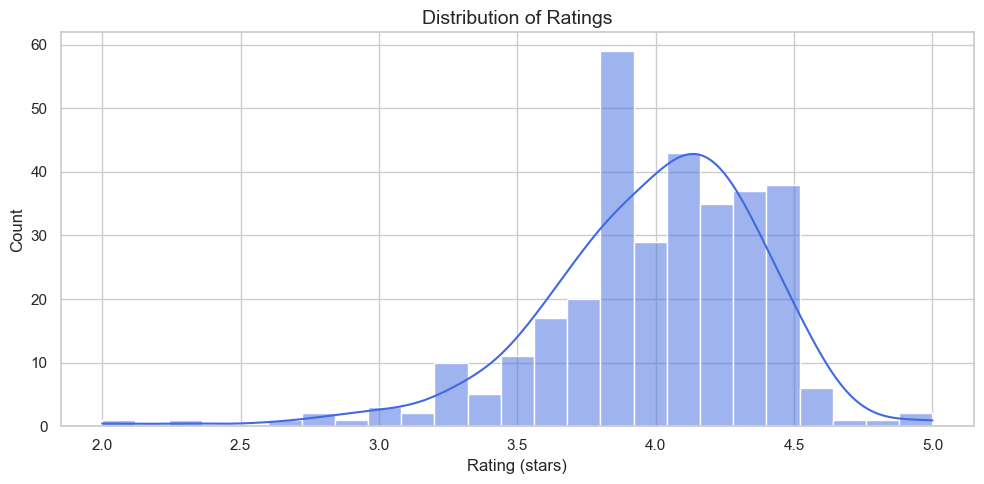

C:\Users\fayaz\AppData\Local\Temp\ipykernel_24312\2452397515.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='actual_price', data=df_top, palette='Set2')
C:\Users\fayaz\AppData\Local\Temp\ipykernel_24312\2452397515.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


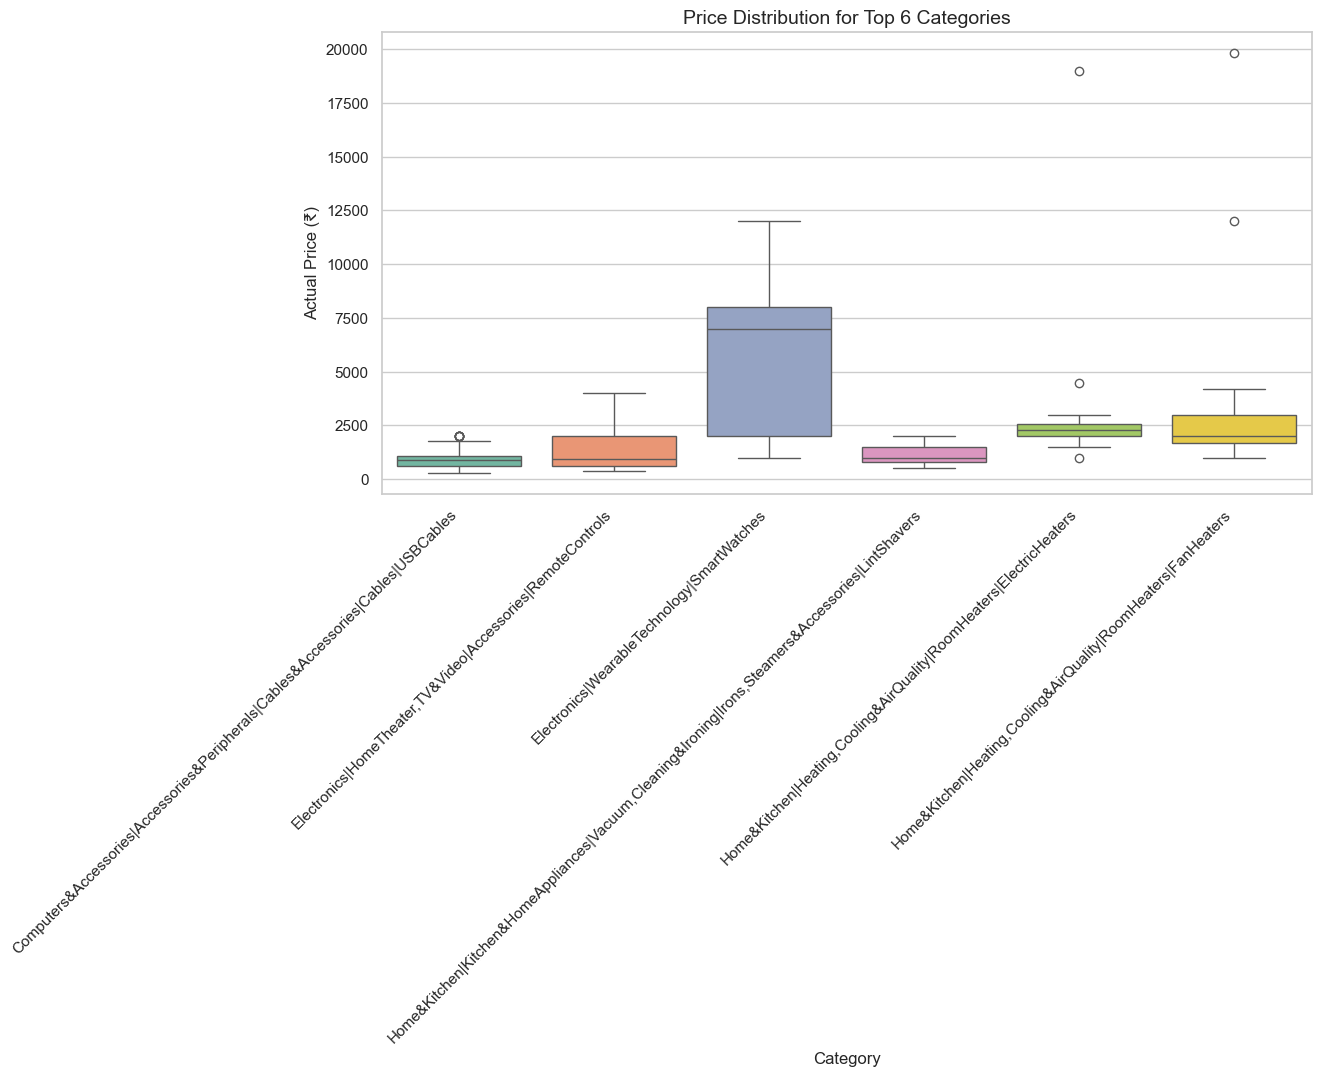

C:\Users\fayaz\AppData\Local\Temp\ipykernel_24312\2452397515.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


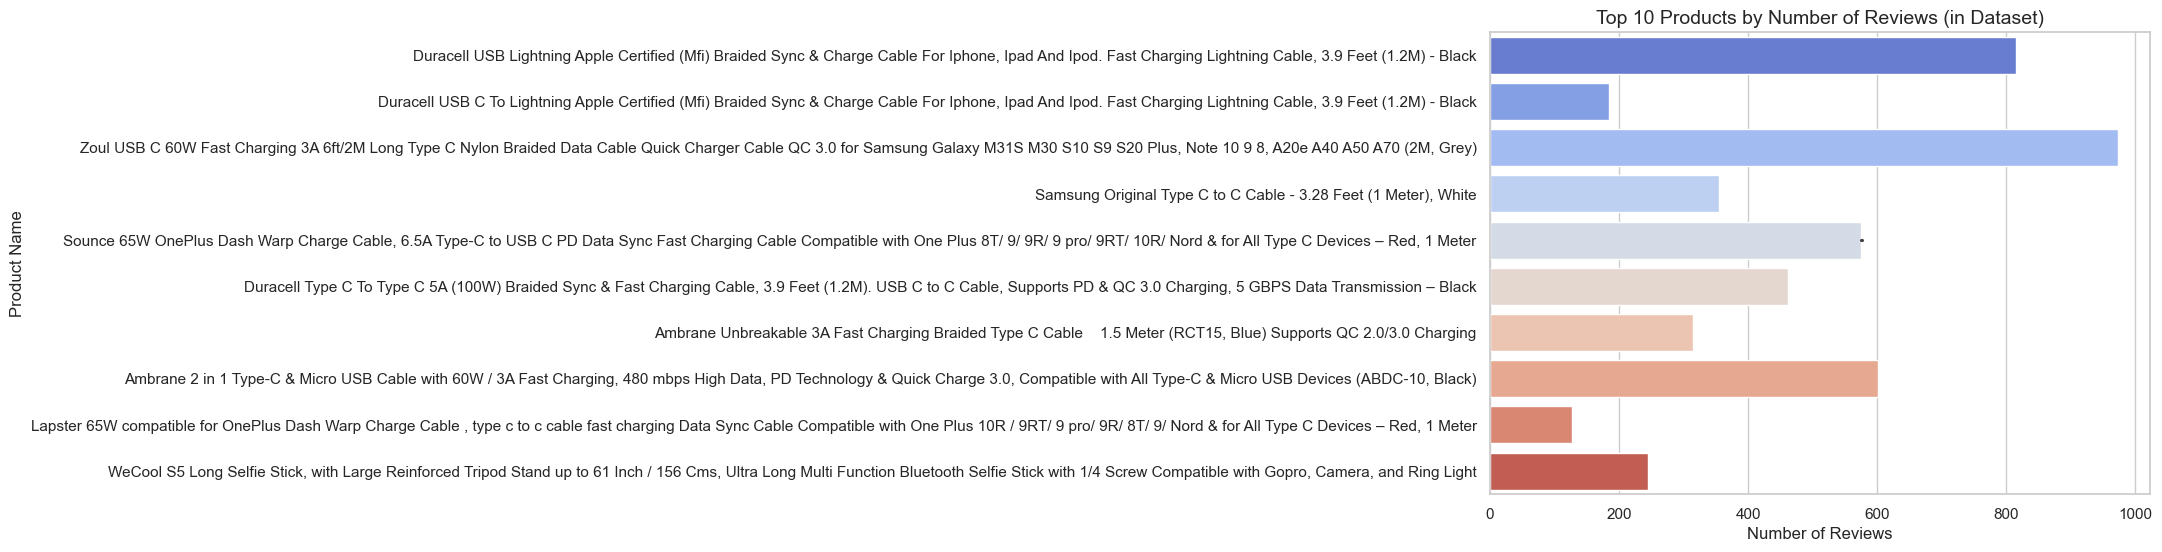

✅ Visualization completed and dataset cleaned successfully — No warnings expected!


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("amazon_cleaned.csv")

# Convert columns to numeric safely
df['actual_price'] = pd.to_numeric(df['actual_price'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

# Drop missing essential values
df = df.dropna(subset=['category', 'actual_price', 'rating', 'rating_count'])

# Set visualization theme
sns.set(style="whitegrid")
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# 1️ Distribution of Ratings

plt.figure(figsize=(10, 5))
sns.histplot(x='rating', data=df, bins=25, kde=True, color='royalblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating (stars)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2️ Price Distribution for Top Categories
top_cats = df['category'].value_counts().head(6).index
df_top = df[df['category'].isin(top_cats)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='actual_price', data=df_top, palette='Set2')
plt.title("Price Distribution for Top 6 Categories")
plt.xlabel("Category")
plt.ylabel("Actual Price (₹)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 3️ Top 10 Products by Number of Reviews
if 'product_name' in df.columns:
    top_products = df['product_name'].value_counts().head(10).index
    df_top_products = df[df['product_name'].isin(top_products)]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='rating_count',
        y='product_name',
        data=df_top_products,
        hue=None,
        palette='coolwarm',
        legend=False
    )
    plt.title("Top 10 Products by Number of Reviews (in Dataset)")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Product Name")
    plt.xticks(rotation=0)
    plt.subplots_adjust(left=0.35)  # give space for long product names
    plt.show()
else:
    print("⚠️ Column 'product_name' not found in dataset.")

# 4️ Save cleaned version
df.to_csv("amazon_visualization_ready.csv", index=False)
print("✅ Visualization completed and dataset cleaned successfully — No warnings expected!")
